# COVID-19: Face Mask Detector


### Created by Cainvas Scholar-
1. Ritik Bompilwar ( [GitHub](https://github.com/RITIK-12) | [LinkedIn](https://www.linkedin.com/in/ritik-bompilwar-6054b818b/) ) 


![facemask](https://cainvas-static.s3.amazonaws.com/media/user_data/cainvas-admin/facemask.gif)




### **Face Mask Detector**

Face Mask Detection system built with OpenCV, TensorFlow using Deep Learning and Computer Vision to detect face masks in real-time video streams. 

#### Full Project is **[here](https://github.com/RITIK-12/Face-Mask-Detector)**

Two-phase COVID-19 face mask detector-

![face_mask_detector](https://cainvas-static.s3.amazonaws.com/media/user_data/cainvas-admin/facemask2.png)

**Dataset :** [Face Mask Detection Data](https://www.kaggle.com/aneerbanchakraborty/face-mask-detection-data) from Kaggle.

**Refrence :** [COVID-19: Face Mask Detector with OpenCV, Keras/TensorFlow, and Deep Learning](https://www.pyimagesearch.com/2020/05/04/covid-19-face-mask-detector-with-opencv-keras-tensorflow-and-deep-learning/)


### **Download the dataset**

In [16]:
!wget -N "https://cainvas-static.s3.amazonaws.com/media/user_data/cainvas-admin/face-mask-detection.zip"
!unzip -q -o "face-mask-detection.zip" -d "face-mask-detection-data"
!rm "face-mask-detection.zip"

--2020-09-20 20:44:42--  https://cainvas-static.s3.amazonaws.com/media/user_data/cainvas-admin/face-mask-detection.zip
Resolving cainvas-static.s3.amazonaws.com (cainvas-static.s3.amazonaws.com)... 52.219.64.100
Connecting to cainvas-static.s3.amazonaws.com (cainvas-static.s3.amazonaws.com)|52.219.64.100|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 133028516 (127M) [application/zip]
Saving to: ‘face-mask-detection.zip’

face-mask-detection 100%[===================>] 126.87M  92.7MB/s    in 1.4s    

2020-09-20 20:44:44 (92.7 MB/s) - ‘face-mask-detection.zip’ saved [133028516/133028516]



### **Importing all the dependencies and required libraries.**

In [2]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import load_model
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from imutils.video import VideoStream
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import argparse
import os
import cv2
import time
import imutils

Loading and labelling the images in the Dataset.

In [3]:
# initialize the initial learning rate, number of epochs to train for,
# and batch size
INIT_LR = 1e-4
EPOCHS = 20
BS = 32

# grab the list of images in our dataset directory, then initialize
# the list of data (i.e., images) and class images

imagePaths = list(paths.list_images('face-mask-detection-data'))
data = []
labels = []

# loop over the image paths
for imagePath in imagePaths:
	# extract the class label from the filename
	label = imagePath.split(os.path.sep)[-2]

	# load the input image (224x224) and preprocess it
	image = load_img(imagePath, target_size=(224, 224))
	image = img_to_array(image)
	image = preprocess_input(image)

	# update the data and labels lists, respectively
	data.append(image)
	labels.append(label)
print("No. of images loaded: {}".format(len(data)))




/opt/tljh/user/lib/python3.7/site-packages/PIL/Image.py:961: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


No. of images loaded: 3833


In [4]:
# convert the data and labels to NumPy arrays
data = np.array(data, dtype="float32")
labels = np.array(labels)

# perform one-hot encoding on the labels
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)


Preparing the inputs for the model

In [5]:
# partition the data into training and testing splits using 75% of
# the data for training and the remaining 25% for testing
(trainX, testX, trainY, testY) = train_test_split(data, labels,
	test_size=0.20, stratify=labels, random_state=42)
# construct the training image generator for data augmentation
aug = ImageDataGenerator(
	rotation_range=20,
	zoom_range=0.15,
	width_shift_range=0.2,
	height_shift_range=0.2,
	shear_range=0.15,
	horizontal_flip=True,
	fill_mode="nearest")

 Constructing and compiling the Model

In [6]:
# loading the MobileNetV2 network, ensuring the head FC layer sets are left off
baseModel = MobileNetV2(weights="imagenet", include_top=False,
	input_tensor=Input(shape=(224, 224, 3)))

# constructing the head of the model that will be placed on top of the base model
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(7, 7))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(128, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(2, activation="softmax")(headModel)

# placing the head FC model on top of the base model (this will become the actual model we will train)
model = Model(inputs=baseModel.input, outputs=headModel)

# loop over all layers in the base model and freeze them so they will not be updated during the first training process
for layer in baseModel.layers:
	layer.trainable = False

# compiling our model

opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="binary_crossentropy", optimizer=opt,
	metrics=["accuracy"])



9412608/9406464 [==============================] - 0s 0us/step


Training the Model

In [7]:
# training the head of the network

H = model.fit(
	aug.flow(trainX, trainY, batch_size=BS),
	steps_per_epoch=len(trainX) // BS,
	validation_data=(testX, testY),
	validation_steps=len(testX) // BS,
	epochs=EPOCHS)




Epoch 1/20
95/95 [==============================] - 61s 642ms/step - loss: 0.3721 - accuracy: 0.8352 - val_loss: 0.1116 - val_accuracy: 0.9674
Epoch 2/20
95/95 [==============================] - 60s 633ms/step - loss: 0.1155 - accuracy: 0.9611 - val_loss: 0.0728 - val_accuracy: 0.9765
Epoch 3/20
95/95 [==============================] - 60s 635ms/step - loss: 0.0869 - accuracy: 0.9710 - val_loss: 0.0560 - val_accuracy: 0.9870
Epoch 4/20
95/95 [==============================] - 60s 629ms/step - loss: 0.0652 - accuracy: 0.9782 - val_loss: 0.0488 - val_accuracy: 0.9870
Epoch 5/20
95/95 [==============================] - 60s 633ms/step - loss: 0.0528 - accuracy: 0.9809 - val_loss: 0.0387 - val_accuracy: 0.9883
Epoch 6/20
95/95 [==============================] - 60s 632ms/step - loss: 0.0508 - accuracy: 0.9809 - val_loss: 0.0378 - val_accuracy: 0.9870
Epoch 7/20
95/95 [==============================] - 60s 633ms/step - loss: 0.0444 - accuracy: 0.9845 - val_loss: 0.0351 - val_accuracy: 0.9883

Predicting masked and unmasked images using the trained Model.

In [8]:
# making predictions on the testing set

predIdxs = model.predict(testX, batch_size=BS)

# for each image in the testing set we need to find the index of the label with corresponding largest predicted probability
predIdxs = np.argmax(predIdxs, axis=1)

# Creating a classification report
print(classification_report(testY.argmax(axis=1), predIdxs,
	target_names=lb.classes_))


              precision    recall  f1-score   support

   with_mask       0.99      1.00      0.99       383
without_mask       1.00      0.99      0.99       384

    accuracy                           0.99       767
   macro avg       0.99      0.99      0.99       767
weighted avg       0.99      0.99      0.99       767



 Plotting the training loss and accuracy

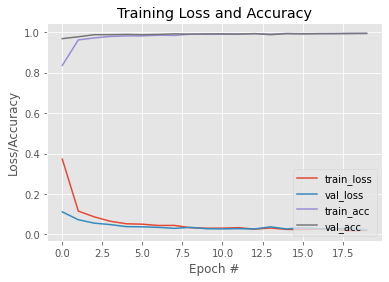

In [9]:

N = EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower right")



### Save model

In [14]:
model.save('face-mask-detector')

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: face-mask-detector/assets


### Compile using deepC

In [ ]:
!deepCC face-mask-detector --format=tensorflow

# Using Realtime Tracking

Click below to see the full video

[![Live Face Mask Detection demo](https://user-images.githubusercontent.com/54806252/93716353-edb0c680-fb8c-11ea-9721-ba3f622b1e92.gif)](https://www.youtube.com/watch?v=ws1a8oOh-_Y)


### Defining face detection/mask prediction function

In [10]:
def detect_and_predict_mask(frame, faceNet, maskNet):
	# grab the dimensions of the frame and then construct a blob
	# from it
	(h, w) = frame.shape[:2]
	blob = cv2.dnn.blobFromImage(frame, 1.0, (300, 300),
		(104.0, 177.0, 123.0))

	# pass the blob through the network and obtain the face detections
	faceNet.setInput(blob)
	detections = faceNet.forward()

	# initialize our list of faces, their corresponding locations,
	# and the list of predictions from our face mask network
	faces = []
	locs = []
	preds = []

	# loop over the detections
	for i in range(0, detections.shape[2]):
		# extract the confidence (i.e., probability) associated with
		# the detection
		confidence = detections[0, 0, i, 2]

		# filter out weak detections by ensuring the confidence is
		# greater than the minimum confidence
		if confidence > args["confidence"]:
			# compute the (x, y)-coordinates of the bounding box for
			# the object
			box = detections[0, 0, i, 3:7] * np.array([w, h, w, h])
			(startX, startY, endX, endY) = box.astype("int")

			# ensure the bounding boxes fall within the dimensions of
			# the frame
			(startX, startY) = (max(0, startX), max(0, startY))
			(endX, endY) = (min(w - 1, endX), min(h - 1, endY))

			# extract the face ROI, convert it from BGR to RGB channel
			# ordering, resize it to 224x224, and preprocess it
			face = frame[startY:endY, startX:endX]
			face = cv2.cvtColor(face, cv2.COLOR_BGR2RGB)
			face = cv2.resize(face, (224, 224))
			face = img_to_array(face)
			face = preprocess_input(face)

			# add the face and bounding boxes to their respective
			# lists
			faces.append(face)
			locs.append((startX, startY, endX, endY))

	# only make a predictions if at least one face was detected
	if len(faces) > 0:
		# for faster inference we'll make batch predictions on *all*
		# faces at the same time rather than one-by-one predictions
		# in the above `for` loop
		faces = np.array(faces, dtype="float32")
		preds = maskNet.predict(faces, batch_size=32)

	# return a 2-tuple of the face locations and their corresponding
	# locations
	return (locs, preds)


Constructing the argument parser and parsing the arguments

In [11]:
args = {}
args["face"] = "face_detector"
args["model"] = "mask_detector.model"
args["confidence"] = 0.4

Loading the Face Detector Model

In [ ]:

prototxtPath = os.path.sep.join([args["face"], "deploy.prototxt"])
weightsPath = os.path.sep.join([args["face"],
	"res10_300x300_ssd_iter_140000.caffemodel"])
faceNet = cv2.dnn.readNet(prototxtPath, weightsPath)



Loading the saved Facemask Detector Model

In [ ]:
# load the face mask detector model from disk

maskNet = load_model(args["model"])

Initializing the webcam video stream and detecting mask 

In [ ]:

print("Starting video stream")

vs = VideoStream(src=0).start()
time.sleep(2.0)

# looping over the frames from the video stream
while True:
	# grab the frame from the threaded video stream and resize it to have a maximum width of 800 pixels
	frame = vs.read()
	frame = imutils.resize(frame, width=800)

	# detect faces in the frame and determine if they are wearing a face mask or not
	(locs, preds) = detect_and_predict_mask(frame, faceNet, maskNet)

	# loop over the detected face locations and their corresponding locations
	for (box, pred) in zip(locs, preds):
		# unpack the bounding box and predictions
		(startX, startY, endX, endY) = box
		(mask, withoutMask) = pred

		# determine the class label and color we'll use to draw the bounding box and text
		label = "Mask" if mask > withoutMask else "No Mask"
		color = (0, 255, 0) if label == "Mask" else (0, 0, 255)

		# include the probability in the label
		label = "{}: {:.2f}%".format(label, max(mask, withoutMask) * 100)

		# display the label and bounding box rectangle on the output frame
		cv2.putText(frame, label, (startX, startY - 10),
			cv2.FONT_HERSHEY_SIMPLEX, 0.45, color, 2)
		cv2.rectangle(frame, (startX, startY), (endX, endY), color, 2)

	# showing the output frame
	cv2.imshow("Frame", frame)
	key = cv2.waitKey(1) & 0xFF

	# if the `q` key was pressed, break from the loop
	if key == ord("q"):
		break


cv2.destroyAllWindows()
vs.stop()
